# Basic Machine Learning for Predicting Thunderstorm Rotation

This module uses basic ML models &ndash; linear regression, logistic regression, decision trees, and random forests &ndash; to predict future rotation in numerically simulated thunderstorms from the National Center for Atmospheric Research (NCAR) convection-allowing ensemble (Schwartz *et al.* 2015).

# References

This notebook refers to a few publications, listed below.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181.

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the commands `pip install scipy`, `pip install tensorflow`, etc.

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
%matplotlib inline
import copy
import warnings
import numpy
import matplotlib.pyplot as pyplot
import utils

warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

MODULE2_DIR_NAME = '.'
SHORT_COURSE_DIR_NAME = '..'

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Find Input Files

The next cell finds input files for the training (2010-14), validation (2015), and testing (2016-17) periods.

In [3]:
training_file_names = utils.find_many_feature_files(
    first_date_string='20100101', last_date_string='20141231')

validation_file_names = utils.find_many_feature_files(
    first_date_string='20150101', last_date_string='20151231')

testing_file_names = utils.find_many_feature_files(
    first_date_string='20160101', last_date_string='20171231')

# Read Data

The next cell reads training, validation, and testing data &ndash; and explores the contents of one file.

In [4]:
(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_feature_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_feature_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_feature_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20151227-0000.csv"...


--------------------------------------------------


Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160224-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160323-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160401-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160415-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160429-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160505-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160511-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_

# Normalization

The next cell does the following.

 - Finds normalization parameters (mean and standard deviation) for each predictor variable, based only on training data.
 - Normalizes training, validation, and testing data &ndash; using normalization parameters found for training data.  In this case "normalization" means transforming to $z$-scores.
 - Ensures that denormalized values = original values.

In [5]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict)

Original values of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "REFL_COM_mean" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


# Linear Regression: Training

In [6]:
linreg_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=0.)

_ = utils.train_linear_regression(
    model_object=linreg_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linreg_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linreg_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 1.817e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


--------------------------------------------------


Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.048e-06 s^-2
Validation bias (mean signed error) = -9.007e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


# Linear Regression: Coefficient Plot

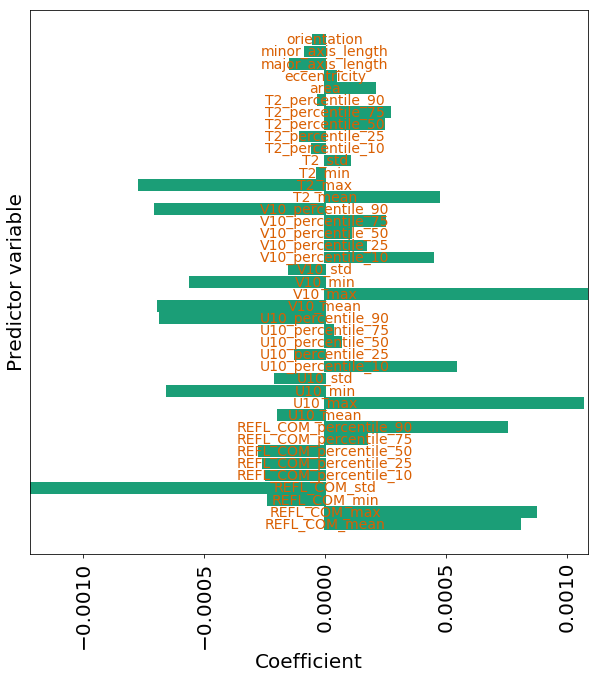

In [7]:
utils.plot_model_coefficients(
    model_object=linreg_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with Ridge: Training

In [8]:
linear_ridge_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=1e5)

_ = utils.train_linear_regression(
    model_object=linear_ridge_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_ridge_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_ridge_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 8.120e-04 s^-1
Training MSE (mean squared error) = 1.255e-06 s^-2
Training bias (mean signed error) = 3.249e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.279
Training MSE skill score (improvement over climatology) = 0.460


--------------------------------------------------


Validation MAE (mean absolute error) = 7.910e-04 s^-1
Validation MSE (mean squared error) = 1.193e-06 s^-2
Validation bias (mean signed error) = 7.027e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.279
Validation MSE skill score (improvement over climatology) = 0.477


# Linear Regression with Ridge: Coefficient Plot

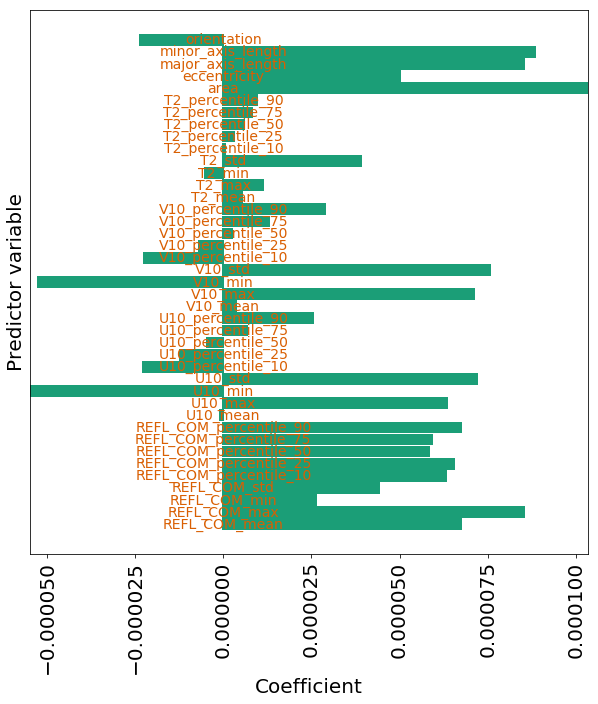

In [9]:
utils.plot_model_coefficients(
    model_object=linear_ridge_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with Lasso: Training

In [10]:
linear_lasso_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=0.)

_ = utils.train_linear_regression(
    model_object=linear_lasso_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_lasso_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_lasso_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 7.893e-04 s^-1
Training MSE (mean squared error) = 1.168e-06 s^-2
Training bias (mean signed error) = 1.664e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.299
Training MSE skill score (improvement over climatology) = 0.497


--------------------------------------------------


Validation MAE (mean absolute error) = 7.669e-04 s^-1
Validation MSE (mean squared error) = 1.103e-06 s^-2
Validation bias (mean signed error) = 1.086e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.301
Validation MSE skill score (improvement over climatology) = 0.516


# Linear Regression with Lasso: Coefficient Plot

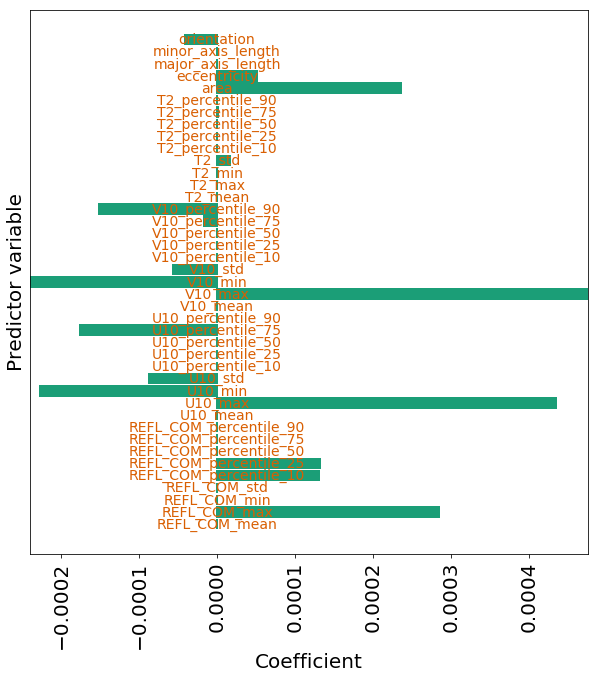

In [11]:
utils.plot_model_coefficients(
    model_object=linear_lasso_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with Elastic Net: Training

In [12]:
linear_en_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=5.)

_ = utils.train_linear_regression(
    model_object=linear_en_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_en_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_en_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 8.554e-04 s^-1
Training MSE (mean squared error) = 1.396e-06 s^-2
Training bias (mean signed error) = 3.467e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.241
Training MSE skill score (improvement over climatology) = 0.399


--------------------------------------------------


Validation MAE (mean absolute error) = 8.370e-04 s^-1
Validation MSE (mean squared error) = 1.344e-06 s^-2
Validation bias (mean signed error) = 4.480e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.237
Validation MSE skill score (improvement over climatology) = 0.410


# Linear Regression with Elastic Net: Coefficient Plot

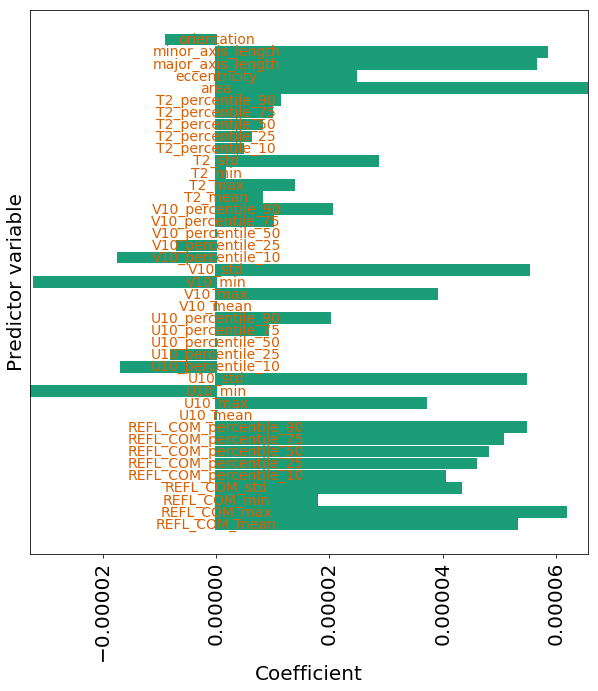

In [13]:
utils.plot_model_coefficients(
    model_object=linear_en_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Hyperparameter Experiment: Training

In [21]:
lambda1_values = numpy.logspace(-8, -4, num=9)
lambda2_values = numpy.logspace(-4, 1, num=11)

num_lambda1 = len(lambda1_values)
num_lambda2 = len(lambda2_values)

validation_mae_matrix_s01 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_matrix_s02 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mae_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)

mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

for i in range(num_lambda1):
    for j in range(num_lambda2):
        this_message_string = (
            'Training model with lasso coeff = 10^{0:.1f}, ridge coeff = '
            '10^{1:.1f}...'
        ).format(
            numpy.log10(lambda1_values[i]), numpy.log10(lambda2_values[j])
        )

        print(this_message_string)

        this_model_object = utils.setup_linear_regression(
            lambda1=lambda1_values[i], lambda2=lambda2_values[j]
        )

        _ = utils.train_linear_regression(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table)

        these_validation_predictions = this_model_object.predict(
            validation_predictor_table.as_matrix()
        )

        this_evaluation_dict = utils.evaluate_regression(
            target_values=validation_target_table[utils.TARGET_NAME].values,
            predicted_target_values=these_validation_predictions,
            mean_training_target_value=mean_training_target_value,
            verbose=False)

        validation_mae_matrix_s01[i, j] = this_evaluation_dict[
            utils.MAE_KEY]
        validation_mse_matrix_s02[i, j] = this_evaluation_dict[
            utils.MSE_KEY]
        validation_mae_skill_matrix[i, j] = this_evaluation_dict[
            utils.MAE_SKILL_SCORE_KEY]
        validation_mse_skill_matrix[i, j] = this_evaluation_dict[
            utils.MSE_SKILL_SCORE_KEY]

Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^1.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-7.5, ridge co

# Hyperparameter Experiment: Validation

Text(0.5, 1.0, 'MSE skill score on validation data')

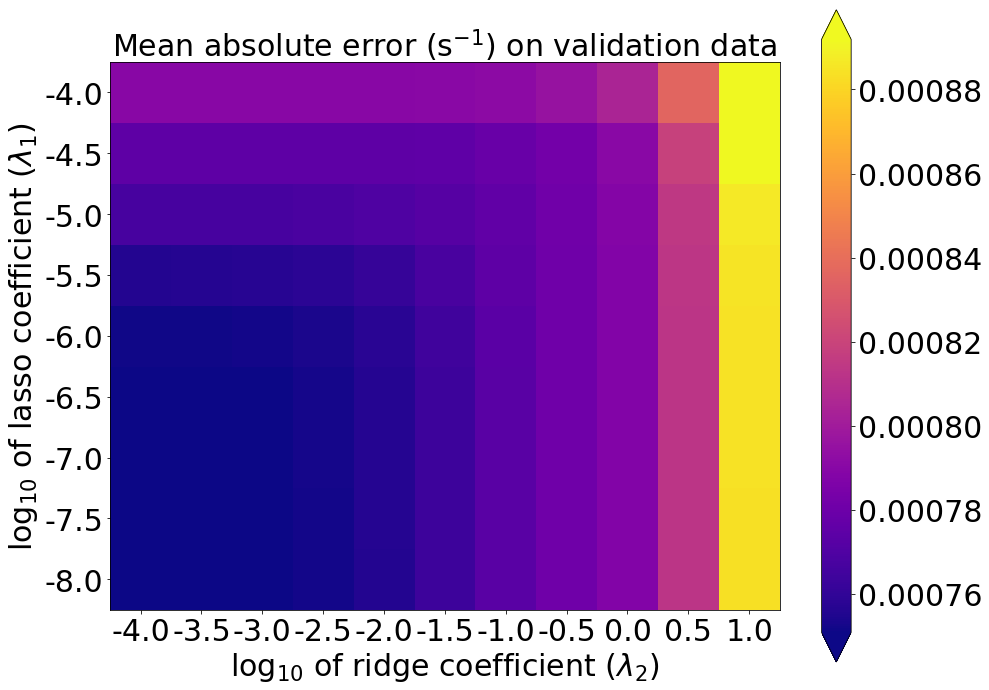

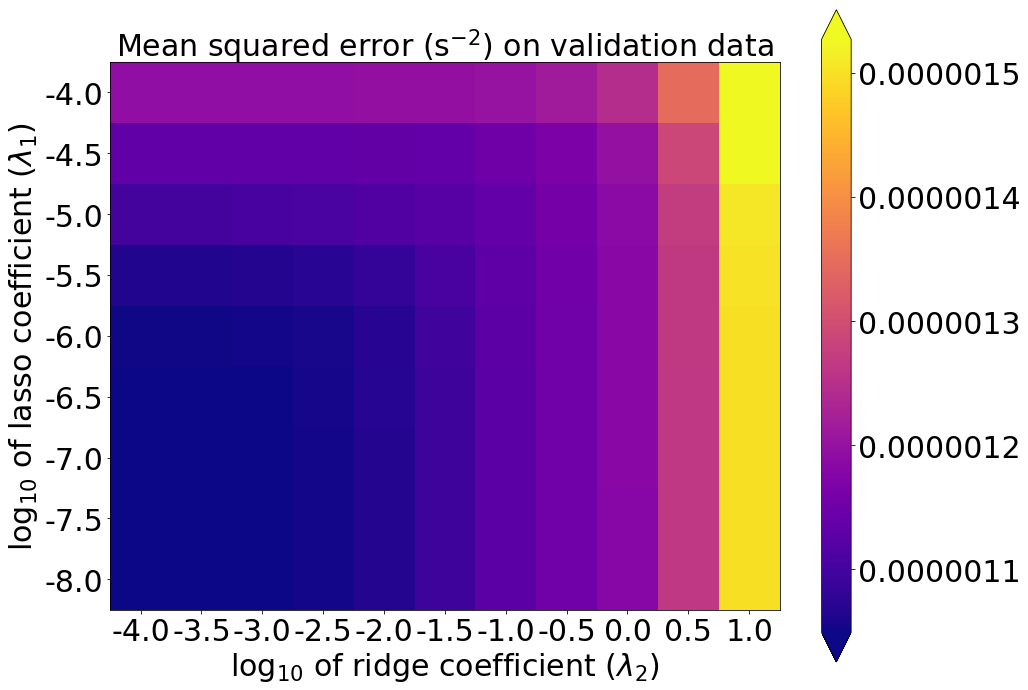

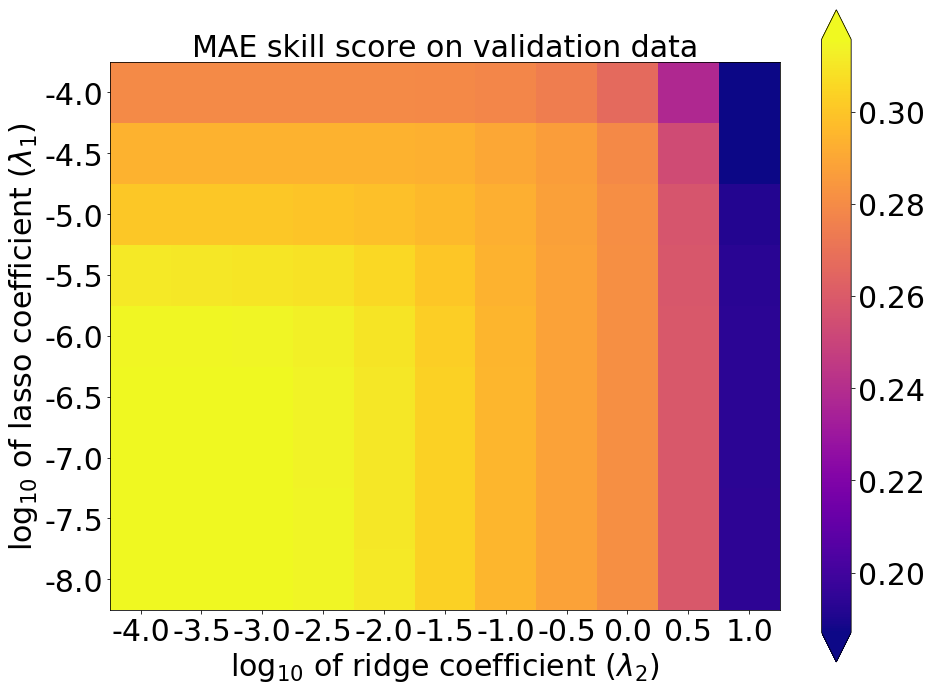

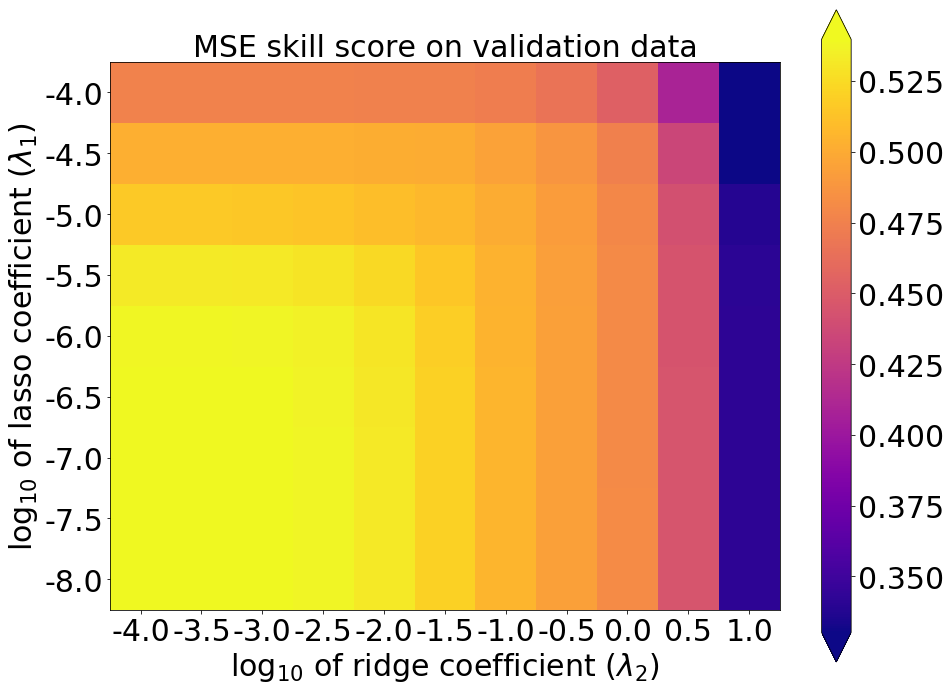

In [39]:
utils.plot_scores_2d(
    score_matrix=validation_mae_matrix_s01,
    min_colour_value=numpy.percentile(validation_mae_matrix_s01, 1.),
    max_colour_value=numpy.percentile(validation_mae_matrix_s01, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean absolute error (s$^{-1}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_matrix_s02,
    min_colour_value=numpy.percentile(validation_mse_matrix_s02, 1.),
    max_colour_value=numpy.percentile(validation_mse_matrix_s02, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean squared error (s$^{-2}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mae_skill_matrix,
    min_colour_value=numpy.percentile(validation_mae_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mae_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MAE skill score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_skill_matrix,
    min_colour_value=numpy.percentile(validation_mse_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mse_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MSE skill score on validation data')

# Hyperparameter Experiment: Select Model

In [40]:
best_linear_index = numpy.argmax(numpy.ravel(validation_mae_skill_matrix))

best_lambda1_index, best_lambda2_index = numpy.unravel_index(
    best_linear_index, (len(lambda1_values), len(lambda2_values))
)

best_lambda1 = lambda1_values[best_lambda1_index]
best_lambda2 = lambda2_values[best_lambda2_index]
best_validation_maess = numpy.max(validation_mae_skill_matrix)

message_string = (
    'Best MAE skill score on validation data = {0:.3f} ... corresponding '
    'lasso coeff = 10^{1:.1f}, ridge coeff = 10^{2:.1f}'
).format(
    best_validation_maess, numpy.log10(best_lambda1),
    numpy.log10(best_lambda2)
)

print(message_string)

final_model_object = utils.setup_linear_regression(
    lambda1=best_lambda1, lambda2=best_lambda2)

_ = utils.train_linear_regression(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

testing_predictions = final_model_object.predict(
    testing_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

this_evaluation_dict = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=testing_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='testing')

Best MAE skill score on validation data = 0.316 ... corresponding lasso coeff = 10^-6.5, ridge coeff = 10^-4.0
Testing MAE (mean absolute error) = 8.257e-04 s^-1
Testing MSE (mean squared error) = 1.413e-06 s^-2
Testing bias (mean signed error) = -8.985e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.338
Testing MSE skill score (improvement over climatology) = 0.555


# Binarization

The next cell does the following.

 - Finds binarization threshold for target variable (max future rotation), based only on training data.  This will be the 90$^{\textrm{th}}$ percentile over all training examples.
 - Binarizes target variable for training, validation, and testing data &ndash; using the threshold found for training data.  "Binarization" means transforming each value to a 0 or 1 (yes or no): 0 if $<$ threshold, 1 if $\ge$ threshold.

In [14]:
binarization_threshold = utils.get_binarization_threshold(
    csv_file_names=training_file_names, percentile_level=90.)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    'Real-numbered target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    '\nBinarized target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

# Logistic Regression: Training

Training Max Peirce score (POD - POFD) = 0.610
Training AUC (area under ROC curve) = 0.882
Training Max CSI (critical success index) = 0.348
Training Brier score = 0.066
Training Brier skill score (improvement over climatology) = 0.270


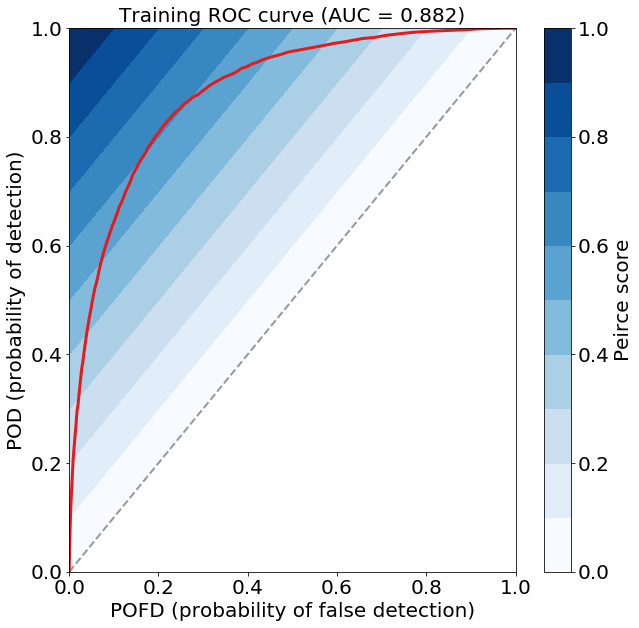

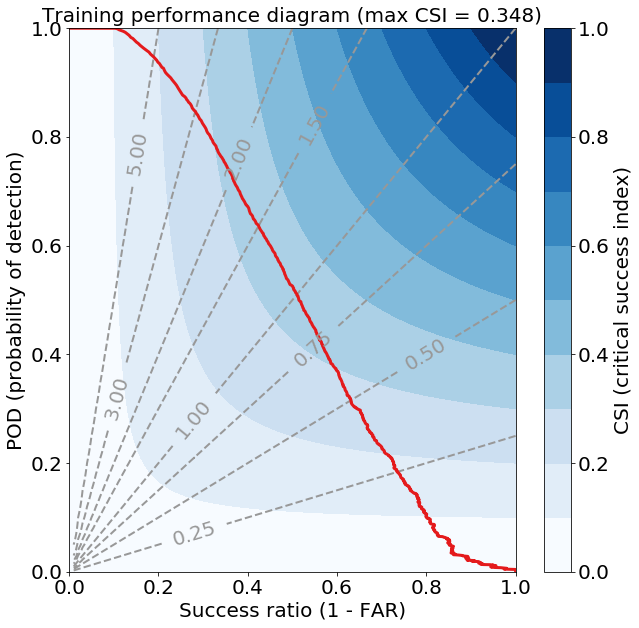

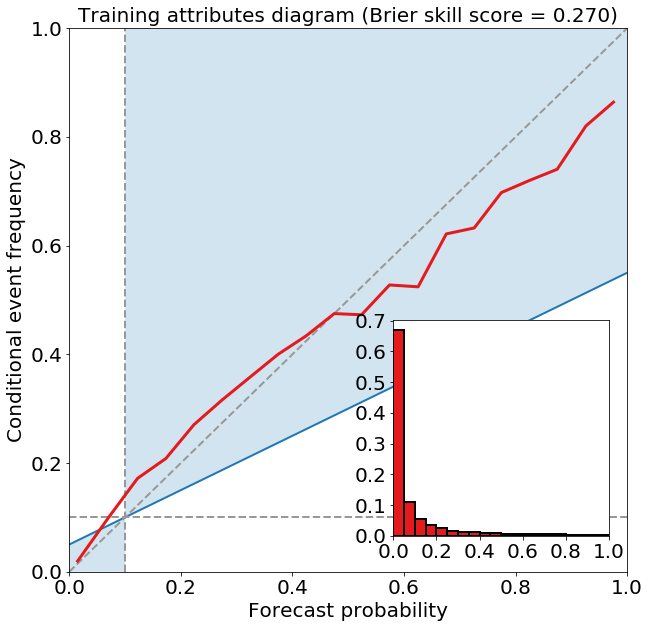

Validation Max Peirce score (POD - POFD) = 0.637
Validation AUC (area under ROC curve) = 0.896
Validation Max CSI (critical success index) = 0.375
Validation Brier score = 0.063
Validation Brier skill score (improvement over climatology) = 0.300


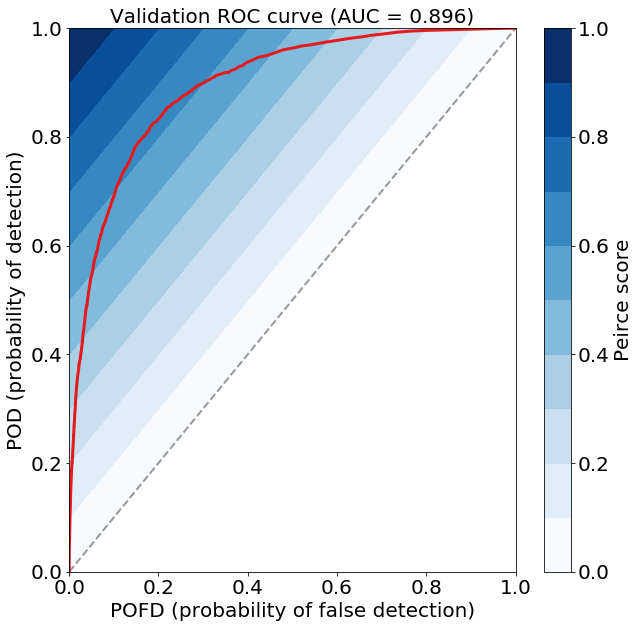

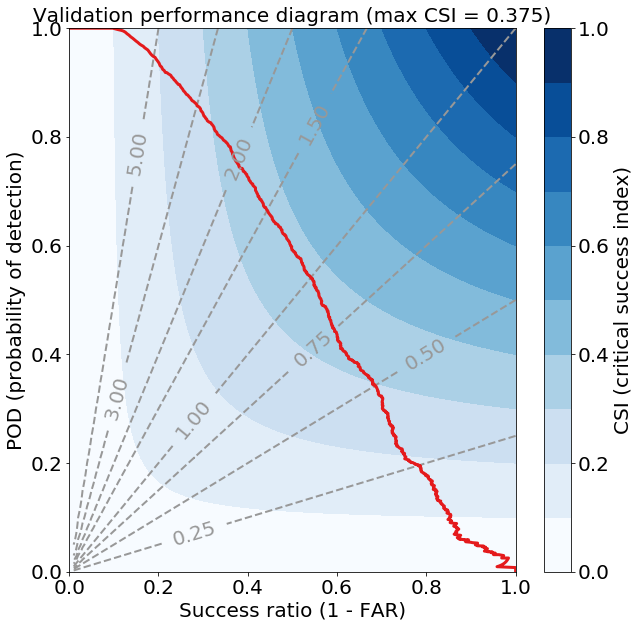

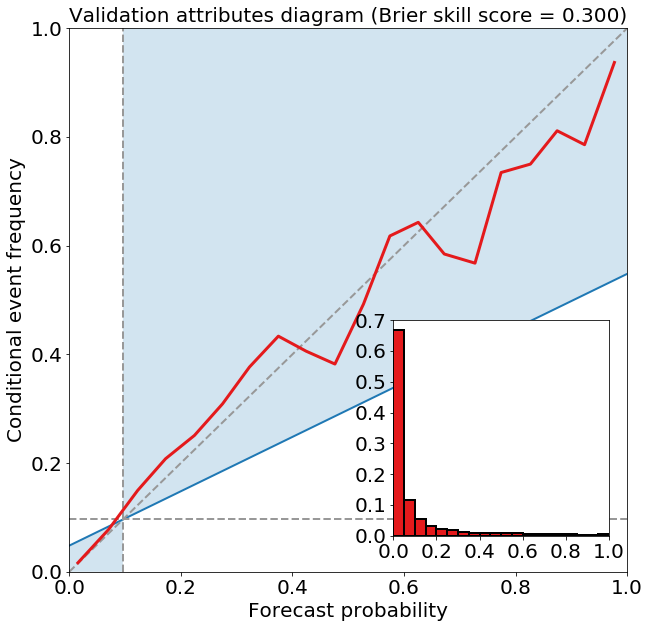

In [15]:
plain_log_model_object = utils.setup_logistic_regression(
    lambda1=0., lambda2=0.)

_ = utils.train_logistic_regression(
    model_object=plain_log_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = plain_log_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = plain_log_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Logistic Regression: Plotting Coefficients

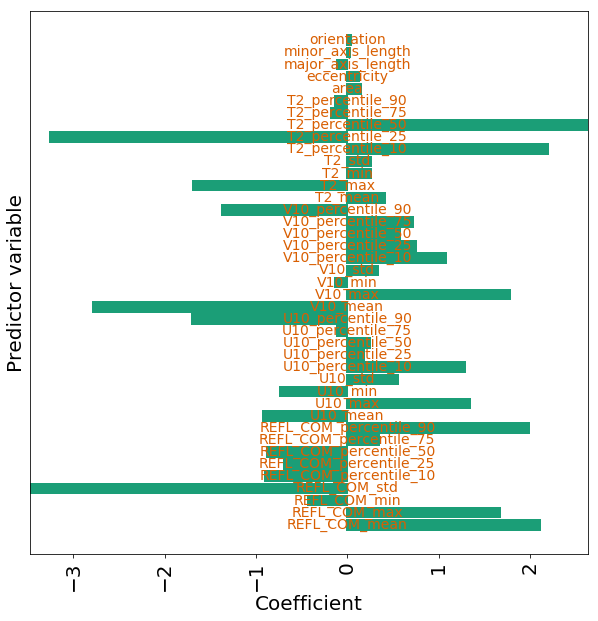

In [16]:
utils.plot_model_coefficients(
    model_object=plain_log_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Logistic Regression with Elastic Net

Validation Max Peirce score (POD - POFD) = 0.663
Validation AUC (area under ROC curve) = 0.907
Validation Max CSI (critical success index) = 0.394
Validation Brier score = 0.061
Validation Brier skill score (improvement over climatology) = 0.321


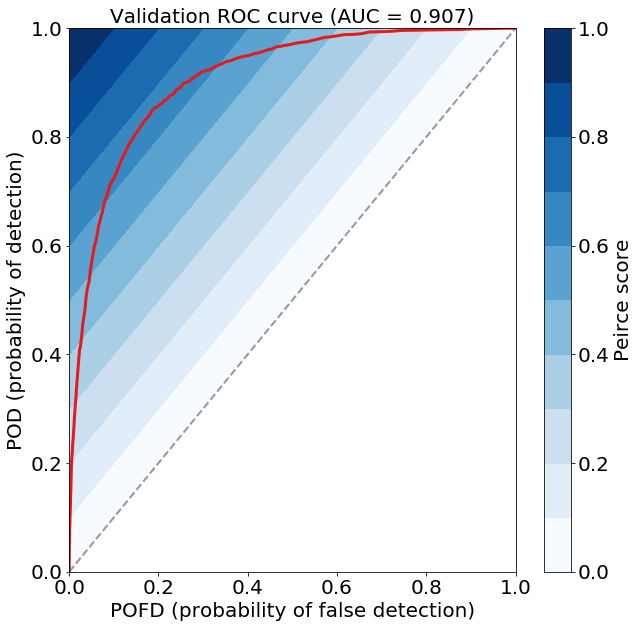

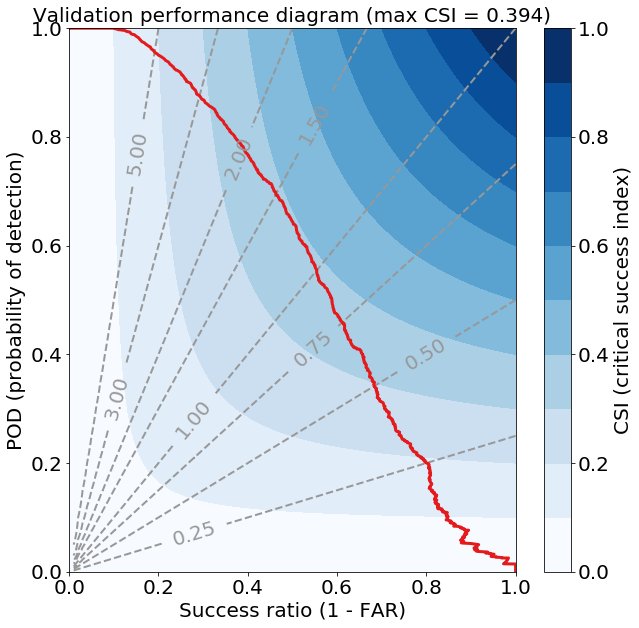

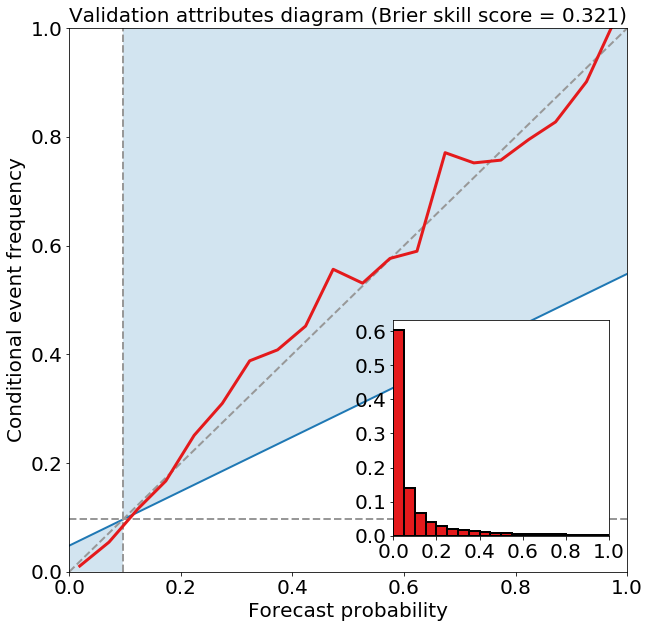

In [17]:
logistic_en_model_object = utils.setup_logistic_regression(
    lambda1=1e-3, lambda2=1e-3)

_ = utils.train_logistic_regression(
    model_object=logistic_en_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

validation_probabilities = logistic_en_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Logistic Regression with Elastic Net: Coefficients

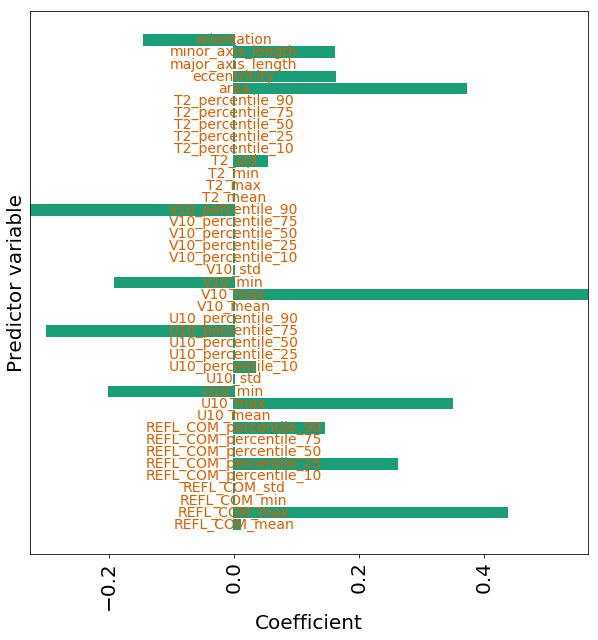

In [18]:
utils.plot_model_coefficients(
    model_object=logistic_en_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Decision Trees

Training Max Peirce score (POD - POFD) = 0.781
Training AUC (area under ROC curve) = 0.955
Training Max CSI (critical success index) = 0.471
Training Brier score = 0.049
Training Brier skill score (improvement over climatology) = 0.459


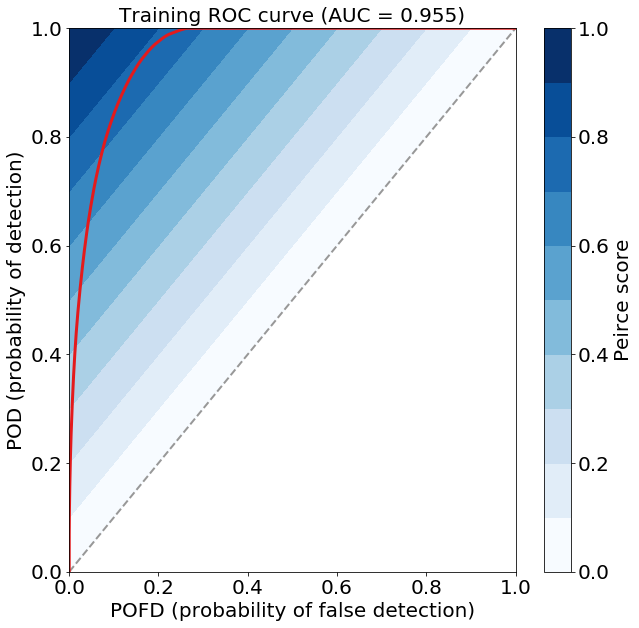

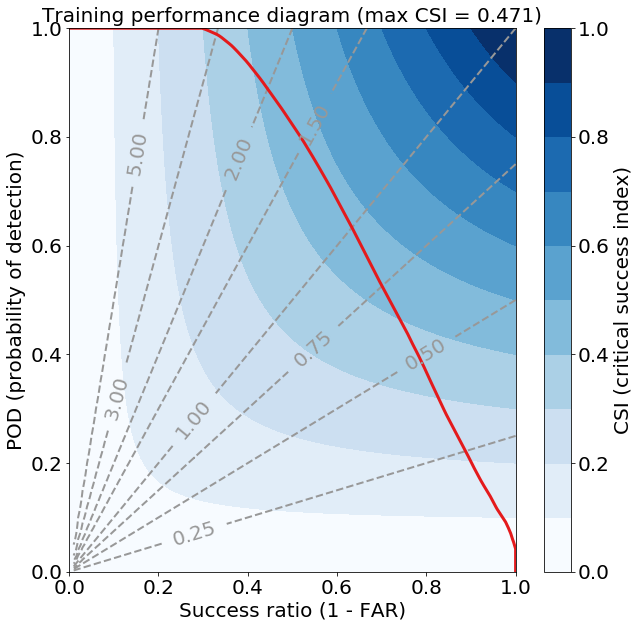

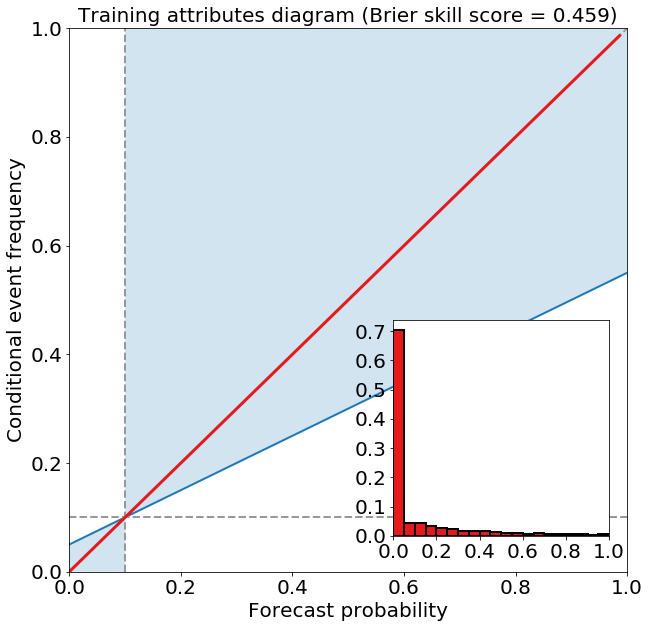

Validation Max Peirce score (POD - POFD) = 0.598
Validation AUC (area under ROC curve) = 0.854
Validation Max CSI (critical success index) = 0.342
Validation Brier score = 0.069
Validation Brier skill score (improvement over climatology) = 0.233


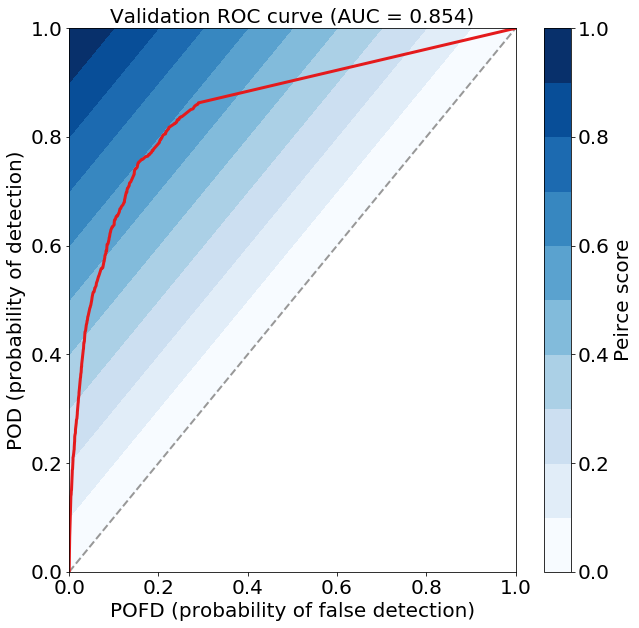

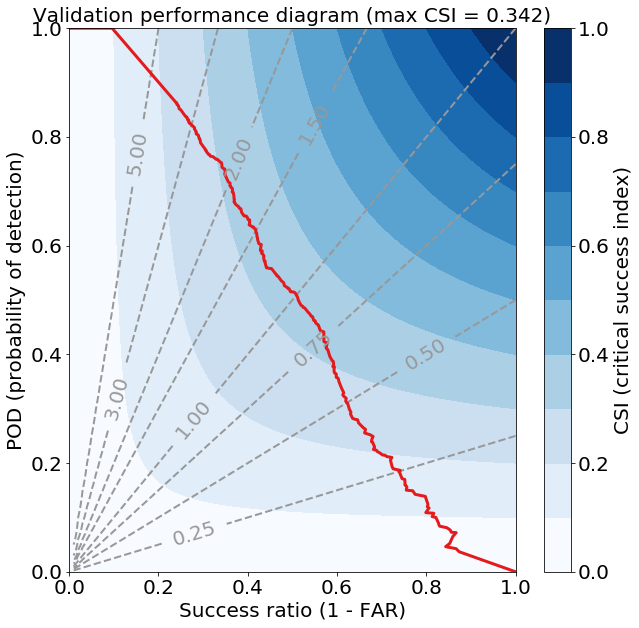

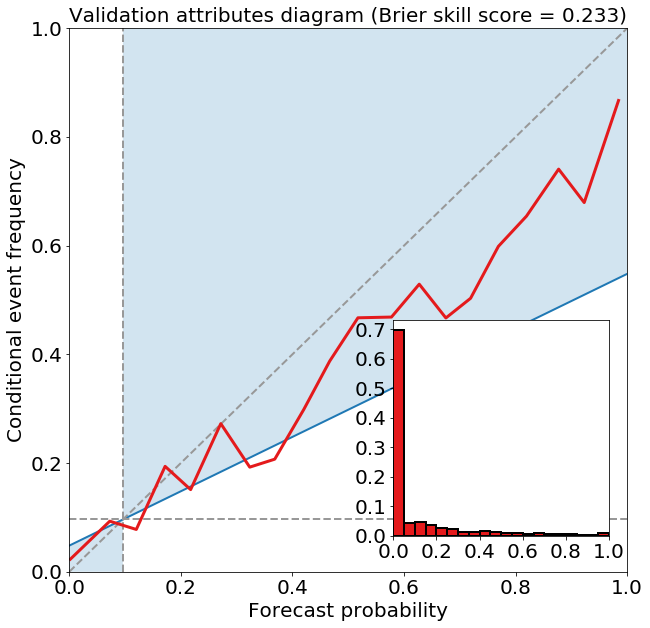

In [19]:
default_tree_model_object = utils.setup_classification_tree(
    min_examples_at_split=30, min_examples_at_leaf=30)

_ = utils.train_classification_tree(
    model_object=default_tree_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = default_tree_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = default_tree_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Hyperparameter Experiment for Trees: Training

In [16]:
min_per_split_values = numpy.array(
    [2, 5, 10, 20, 30, 40, 50, 100, 200, 500], dtype=int)
min_per_leaf_values = numpy.array(
    [1, 5, 10, 20, 30, 40, 50, 100, 200, 500], dtype=int)

num_min_per_split_values = len(min_per_split_values)
num_min_per_leaf_values = len(min_per_leaf_values)

validation_auc_matrix = numpy.full(
    (num_min_per_split_values, num_min_per_leaf_values), numpy.nan
)

validation_max_csi_matrix = validation_auc_matrix + 0.
validation_bs_matrix = validation_auc_matrix + 0.
validation_bss_matrix = validation_auc_matrix + 0.

training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

for i in range(num_min_per_split_values):
    for j in range(num_min_per_leaf_values):
        if min_per_leaf_values[j] >= min_per_split_values[i]:
            continue

        this_message_string = (
            'Training model with minima of {0:d} examples per split node, '
            '{1:d} per leaf node...'
        ).format(min_per_split_values[i], min_per_leaf_values[j])

        print(this_message_string)

        this_model_object = utils.setup_classification_tree(
            min_examples_at_split=min_per_split_values[i],
            min_examples_at_leaf=min_per_leaf_values[j]
        )

        _ = utils.train_classification_tree(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table)

        these_validation_predictions = this_model_object.predict_proba(
            validation_predictor_table.as_matrix()
        )[:, 1]

        this_evaluation_dict = utils.eval_binary_classifn(
            observed_labels=validation_target_table[
                utils.BINARIZED_TARGET_NAME].values,
            forecast_probabilities=these_validation_predictions,
            training_event_frequency=training_event_frequency,
            create_plots=False, verbose=False)

        validation_auc_matrix[i, j] = this_evaluation_dict[utils.AUC_KEY]
        validation_max_csi_matrix[i, j] = this_evaluation_dict[
            utils.MAX_CSI_KEY]
        validation_bs_matrix[i, j] = this_evaluation_dict[
            utils.BRIER_SCORE_KEY]
        validation_bss_matrix[i, j] = this_evaluation_dict[
            utils.BRIER_SKILL_SCORE_KEY]

Training model with minima of 2 examples per split node, 1 per leaf node...
Training model with minima of 5 examples per split node, 1 per leaf node...
Training model with minima of 10 examples per split node, 1 per leaf node...
Training model with minima of 10 examples per split node, 5 per leaf node...
Training model with minima of 20 examples per split node, 1 per leaf node...
Training model with minima of 20 examples per split node, 5 per leaf node...
Training model with minima of 20 examples per split node, 10 per leaf node...
Training model with minima of 30 examples per split node, 1 per leaf node...
Training model with minima of 30 examples per split node, 5 per leaf node...
Training model with minima of 30 examples per split node, 10 per leaf node...
Training model with minima of 30 examples per split node, 20 per leaf node...
Training model with minima of 40 examples per split node, 1 per leaf node...
Training model with minima of 40 examples per split node, 5 per leaf node..

# Hyperparameter Experiment for Trees: Validation

Text(0.5, 1.0, 'Brier skill score on validation data')

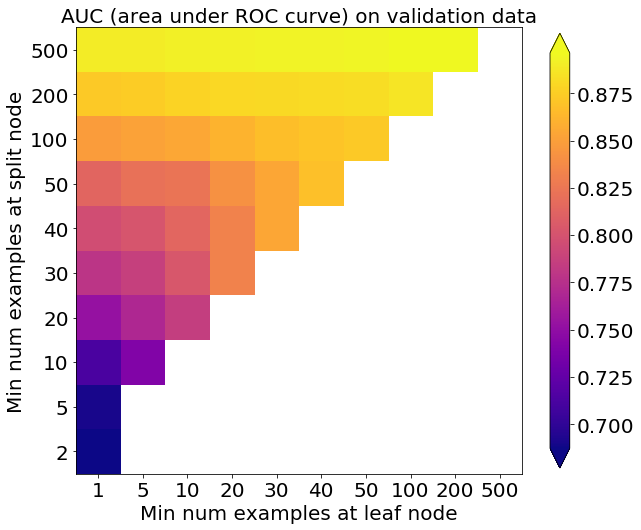

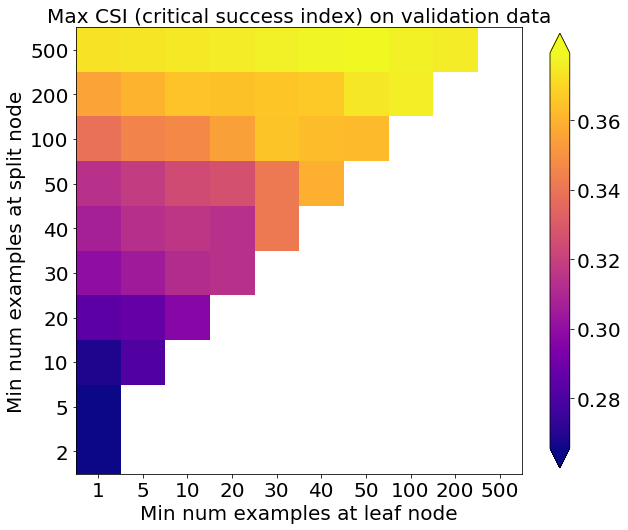

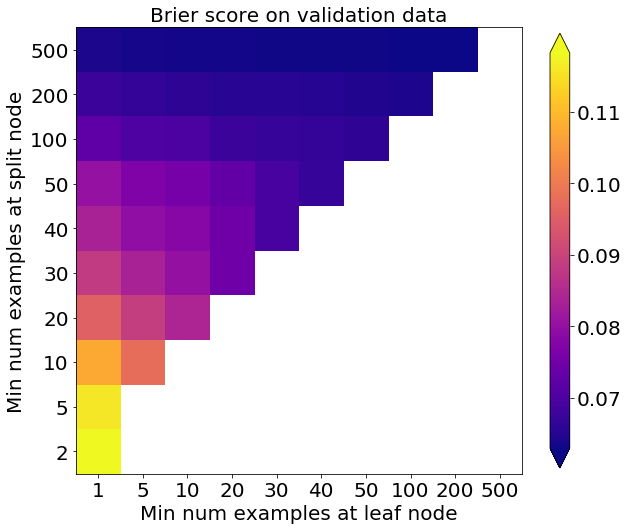

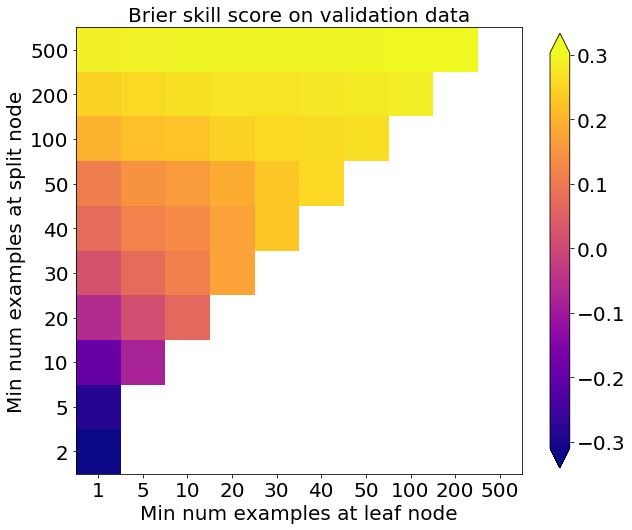

In [17]:
utils.plot_scores_2d(
    score_matrix=validation_auc_matrix,
    min_colour_value=numpy.nanpercentile(validation_auc_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_auc_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('AUC (area under ROC curve) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_max_csi_matrix,
    min_colour_value=numpy.nanpercentile(validation_max_csi_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_max_csi_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Max CSI (critical success index) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bs_matrix,
    min_colour_value=numpy.nanpercentile(validation_bs_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_bs_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Brier score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bss_matrix,
    min_colour_value=numpy.nanpercentile(validation_bss_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_bss_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Brier skill score on validation data')

# Hyperparameter Experiment for Trees: Select Model

Best validation BSS = 0.304 ... corresponding min examples per split node = 500 ... min examples per leaf node = 200
Uncertainty = 0.0903 ... reliability = 0.0007 ... resolution = 0.0379
Testing Max Peirce score (POD - POFD) = 0.657
Testing AUC (area under ROC curve) = 0.900
Testing Max CSI (critical success index) = 0.423
Testing Brier score = 0.053
Testing Brier skill score (improvement over climatology) = 0.412


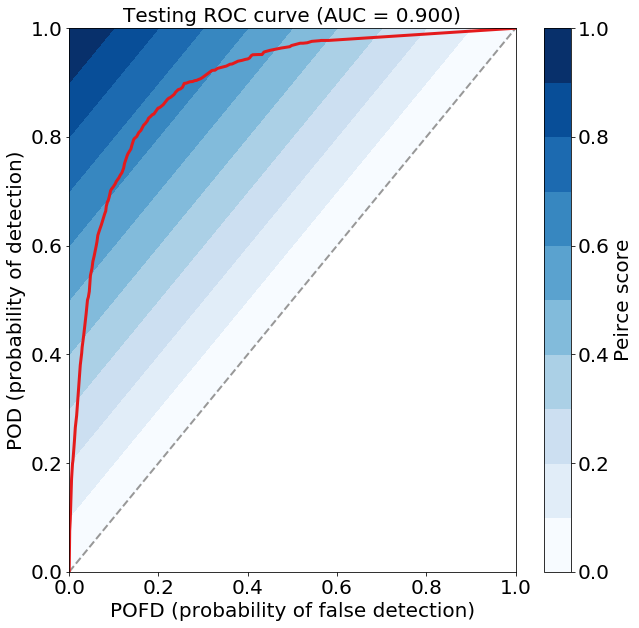

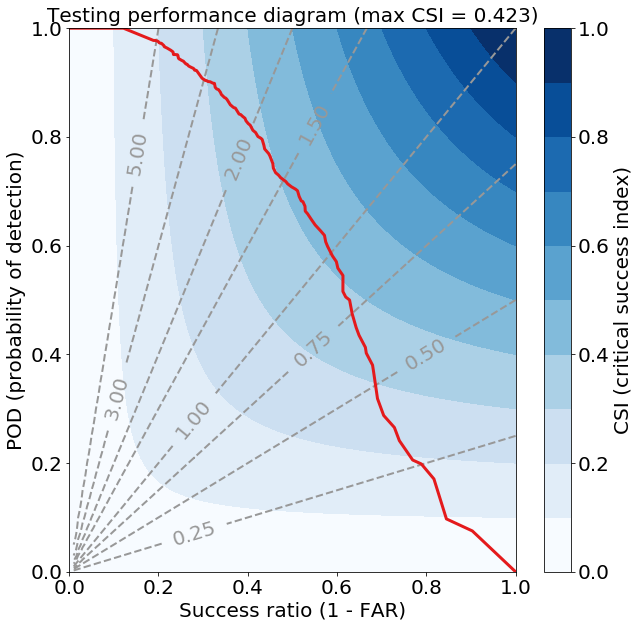

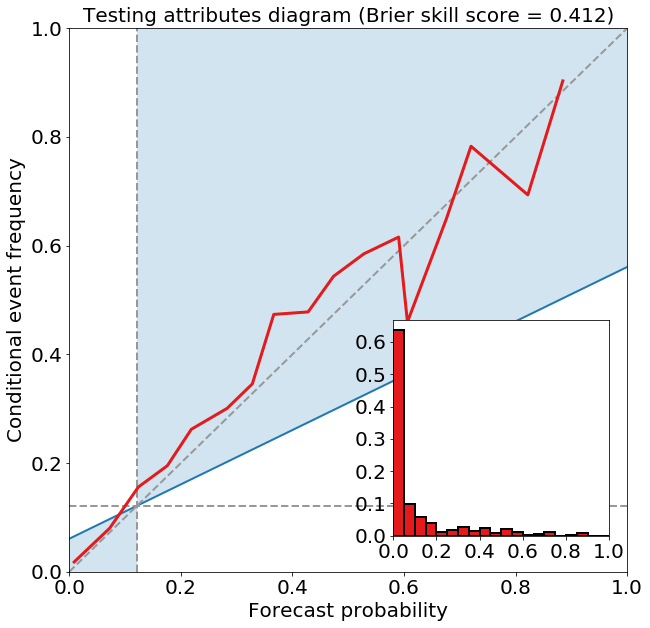

In [19]:
best_linear_index = numpy.nanargmax(numpy.ravel(validation_bss_matrix))

best_split_index, best_leaf_index = numpy.unravel_index(
    best_linear_index, validation_bss_matrix.shape)

best_min_examples_per_split = min_per_split_values[best_split_index]
best_min_examples_per_leaf = min_per_leaf_values[best_leaf_index]
best_validation_bss = numpy.nanmax(validation_bss_matrix)

message_string = (
    'Best validation BSS = {0:.3f} ... corresponding min examples per split'
    ' node = {1:d} ... min examples per leaf node = {2:d}'
).format(
    best_validation_bss, best_min_examples_per_split,
    best_min_examples_per_leaf
)

print(message_string)

final_model_object = utils.setup_classification_tree(
    min_examples_at_split=best_min_examples_per_split,
    min_examples_at_leaf=best_min_examples_per_leaf
)

_ = utils.train_classification_tree(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

testing_predictions = final_model_object.predict_proba(
    testing_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=testing_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=testing_predictions,
    training_event_frequency=training_event_frequency,
    create_plots=True, verbose=True, dataset_name='testing')

# Random Forests

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


Training Max Peirce score (POD - POFD) = 0.675
Training AUC (area under ROC curve) = 0.917
Training Max CSI (critical success index) = 0.394
Training Brier score = 0.060
Training Brier skill score (improvement over climatology) = 0.335


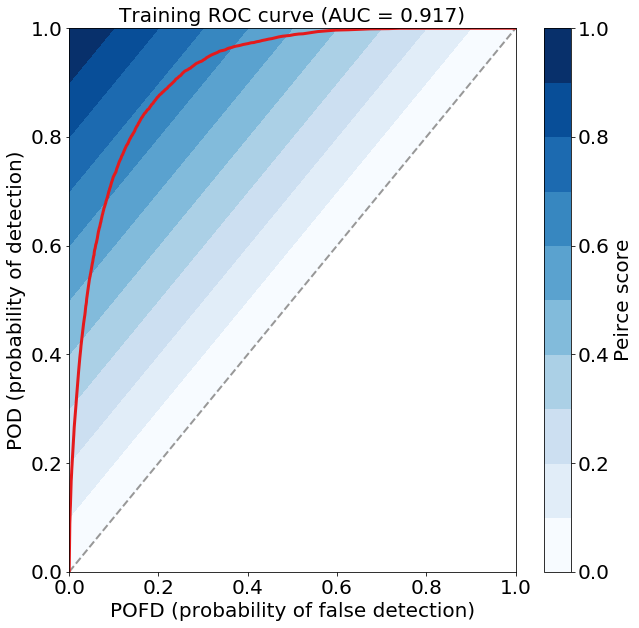

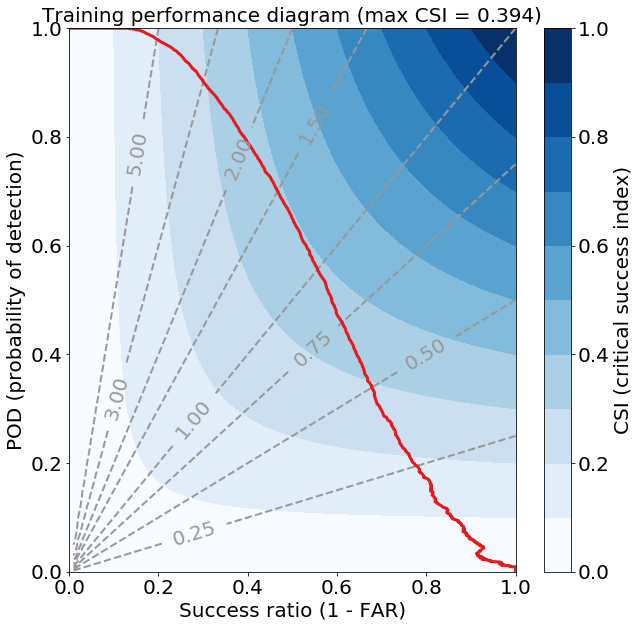

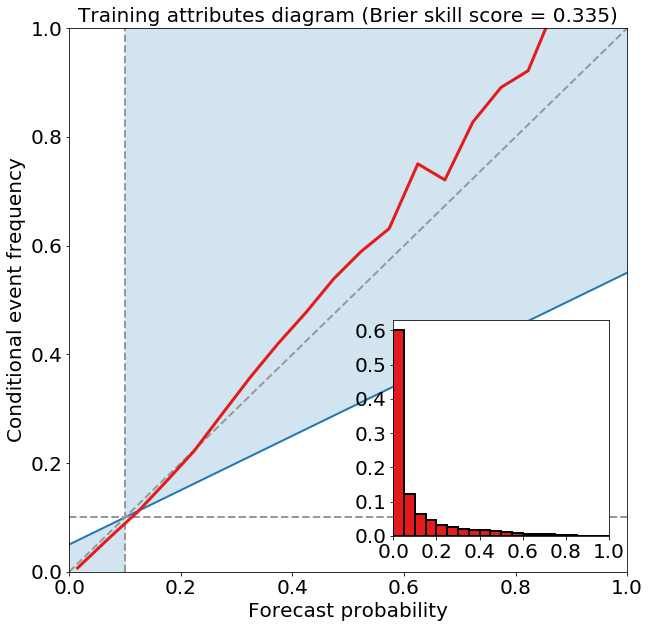

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Validation Max Peirce score (POD - POFD) = 0.670
Validation AUC (area under ROC curve) = 0.913
Validation Max CSI (critical success index) = 0.401
Validation Brier score = 0.061
Validation Brier skill score (improvement over climatology) = 0.328


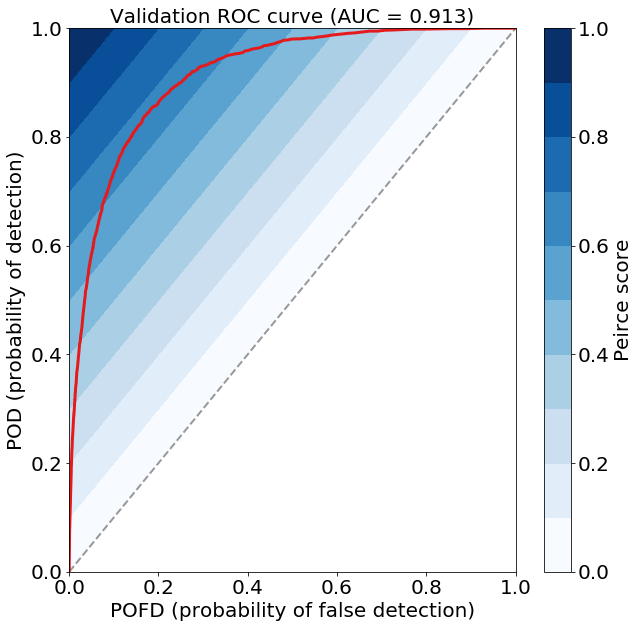

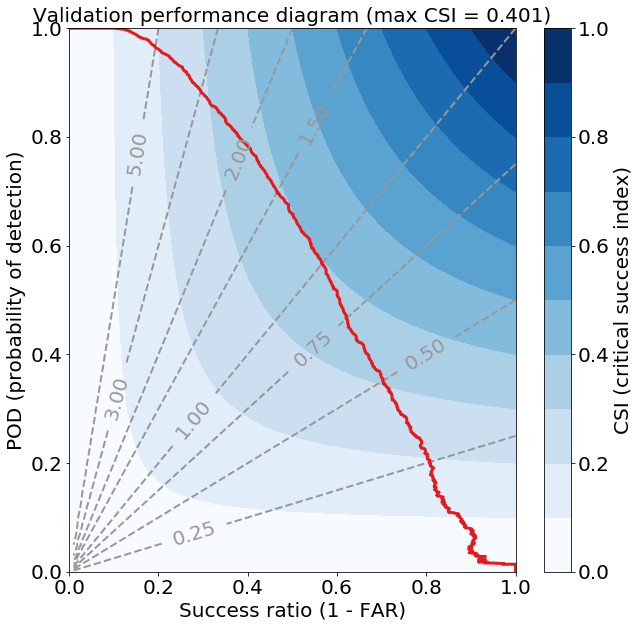

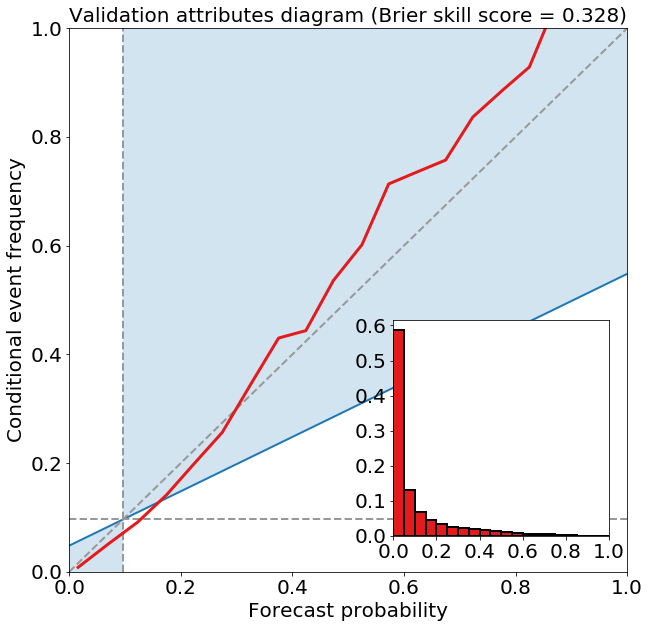

In [20]:
num_predictors = len(list(training_predictor_table))
max_predictors_per_split = int(numpy.round(
    numpy.sqrt(num_predictors)
))

random_forest_model_object = utils.setup_classification_forest(
    max_predictors_per_split=max_predictors_per_split,
    min_examples_at_split=500, min_examples_at_leaf=200)

_ = utils.train_classification_forest(
    model_object=random_forest_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = random_forest_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = random_forest_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Gradient-boosted Trees

# Next Steps

 - Add clustering example.
 - Add reliability curves for regression?
 - Add explanations.
 - Maybe add example with 3-class classification.